In [23]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm import tqdm

custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"

In [10]:
import lightning as L
from txtox.data.datamodules import AnnDataGraphDataModule
from txtox.models.gnn_het_reg import LitGNNHetReg
from txtox.utils import get_paths

n_genes = 500
n_labels = 126
paths = get_paths()

# data
datamodule = AnnDataGraphDataModule(data_dir=paths["data_root"], file_names=["VISp_nhood.h5ad"], batch_size=1)

# model
expname = "20241107_105625_VISp_nhood_GNNhetReg_attres"
checkpoint_path = paths["data_root"] + f"checkpoints/{expname}"
model = LitGNNHetReg.load_from_checkpoint(
    checkpoint_path + "/epoch=179-val_rmse_overall=0.21.ckpt", input_size=n_genes, n_labels=n_labels
)

# setup for predictions
trainer = L.Trainer()
predictions = trainer.predict(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [11]:
xyz_pred = np.concatenate([p[0].reshape(1, -1) for p in predictions], axis=0)
xyz_L_pred = np.concatenate([p[1].reshape(1, 3, 3) for p in predictions], axis=0)
celltype_pred = np.concatenate([p[2].reshape(1, -1) for p in predictions], axis=0)
print(xyz_pred.shape)
print(xyz_L_pred.shape)
print(celltype_pred.shape)

(61884, 3)
(61884, 3, 3)
(61884, 126)


In [12]:
# convert L to covariance matrices using L @ L.T
xyz_cov_pred = xyz_L_pred @ xyz_L_pred.transpose(0, 2, 1)
print(xyz_cov_pred.shape)

(61884, 3, 3)


In [13]:
# del predictions
xyz = []
celltype = []

for batch in tqdm(datamodule.predict_dataloader()):
    _, _, xyz_batch, celltype_batch = batch
    xyz.append(xyz_batch.squeeze(0)[-1, :].numpy())
    celltype.append(celltype_batch.squeeze(0)[-1].numpy().reshape(-1))

xyz = np.array(xyz)

100%|██████████| 61884/61884 [04:56<00:00, 208.85it/s]


In [14]:
# calculates the eigenvalues and eigenvectors for all covariance matrices
eigvals, eigvecs = np.linalg.eig(xyz_cov_pred)

In [15]:
# check if the eigenvectors are columns of the covariance matrix
ind = 100
sigma = xyz_cov_pred[ind].squeeze()
v0 = eigvecs[ind, :, 0]
v1 = eigvecs[ind, :, 1]
v2 = eigvecs[ind, :, 2]

lam = eigvals[ind, :]
# check if the eigenvectors are columns
assert np.allclose(sigma @ v0 / v0, lam[0])
assert np.allclose(sigma @ v1 / v1, lam[1])
assert np.allclose(sigma @ v2 / v2, lam[2])

assert np.allclose(np.linalg.norm(v0, axis=0), 1)
assert np.allclose(np.linalg.norm(v1, axis=0), 1)
assert np.allclose(np.linalg.norm(v2, axis=0), 1)

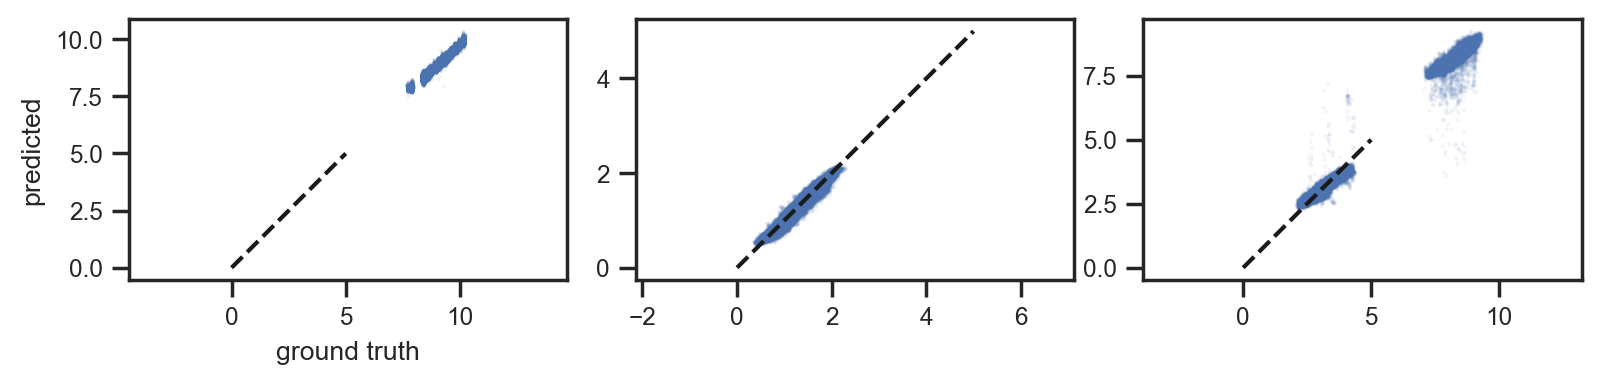

In [16]:
# rough checks for order of the cells in xyz (ground truth) and xyz_pred (predictions)
fig, ax = plt.subplots(1, 3, figsize=(8, 2))
for i in range(3):
    ax[i].scatter(xyz[:, i], xyz_pred[:, i], s=0.1, alpha=0.1)
    ax[i].plot([0, 5], [0, 5], c="k", ls="--")  # 1-1 line
    ax[i].axis("equal")
ax[0].set(xlabel="ground truth", ylabel="predicted")
plt.tight_layout()
plt.show()

In [17]:
path = get_paths()["data_root"] + "VISp_nhood.h5ad"
adata = ad.read_h5ad(path)

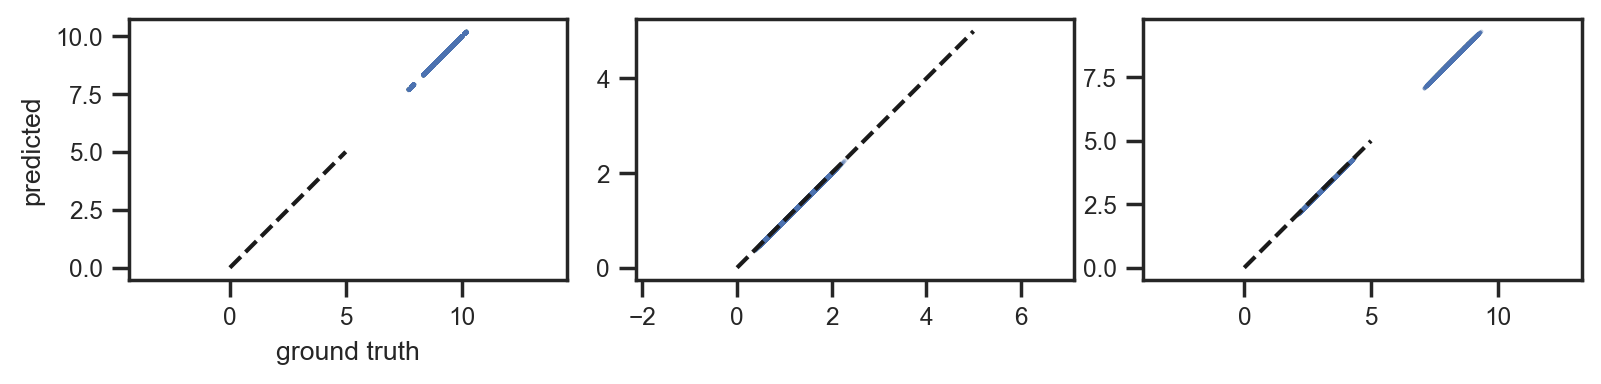

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2))
for i, coord in enumerate(["x_ccf", "y_ccf", "z_ccf"]):
    ax[i].scatter(adata.obs[coord], xyz[:, i], s=0.1, alpha=0.1)
    ax[i].plot([0, 5], [0, 5], c="k", ls="--")  # 1-1 line
    ax[i].axis("equal")
ax[0].set(xlabel="ground truth", ylabel="predicted")
plt.tight_layout()
plt.show()

In [19]:
display(adata.obs["z_section"].value_counts().to_frame())
print(np.sum(adata.obs["z_section"] == 5.4))

,count
z_section,
5.0,9242
4.8,8713
4.6,7780
5.4,6939
5.6,6662
4.2,6379
4.0,4449
4.4,3956
5.8,2913


6939


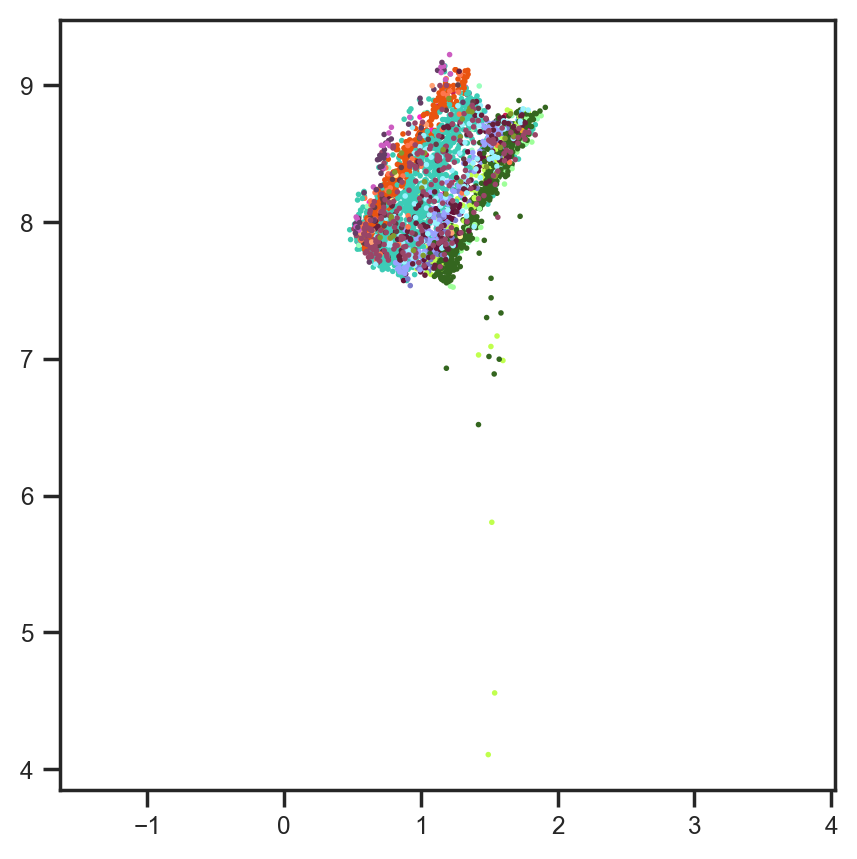

In [20]:
ind = np.where((adata.obs["z_section"] == 5.4) & (adata.obs["z_ccf"] > 6))[0]
f, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.scatter(xyz_pred[ind, 1], xyz_pred[ind, 2], s=1, c=adata.obs["subclass_color"].iloc[ind], alpha=1)
plt.axis("equal")
plt.show()

In [21]:
# this should be zero!
print(f"x: {(adata.obs['x_ccf'] - xyz[:, 0]).mean() * 1e3:0.5f} in um")
print(f"y: {(adata.obs['y_ccf'] - xyz[:, 1]).mean() * 1e3:0.5f} in um")
print(f"z: {(adata.obs['z_ccf'] - xyz[:, 2]).mean() * 1e3:0.5f} in um")

x: -0.00000 in um
y: -0.00000 in um
z: 0.00000 in um


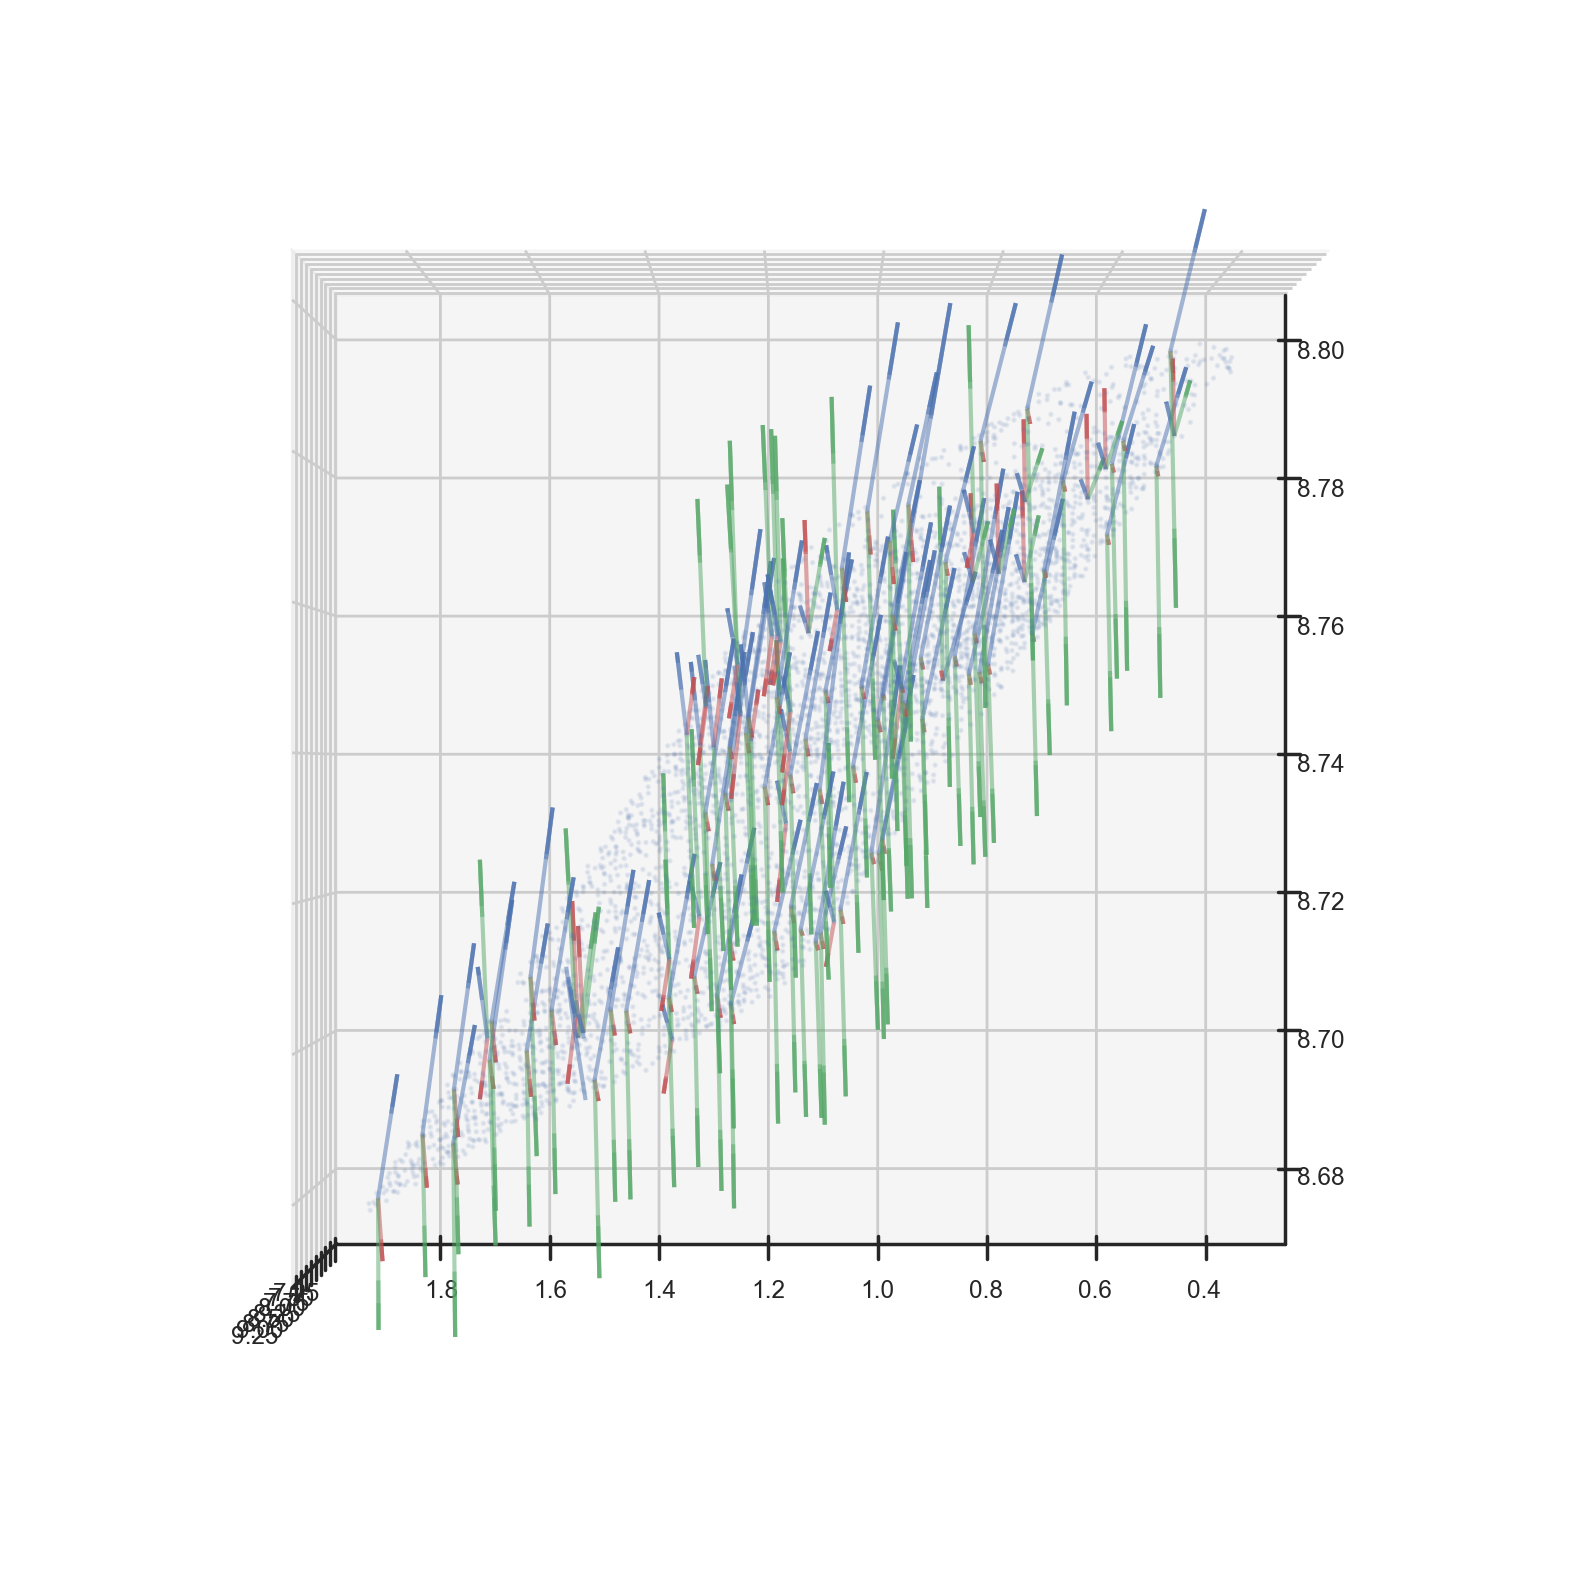

In [22]:
ind = np.where((adata.obs["z_section"] == 5.4) & (adata.obs["z_ccf"] > 6))[0]
scale = 0.2  # scales the length of the eigenvectors


n_arrows = 100  # number of points to show eigenvectors for
step = len(xyz[ind]) // n_arrows
colors = ["r", "g", "b"]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=90, azim=180, roll=0)
ax.scatter(xyz[ind, 0], xyz[ind, 1], xyz[ind, 2], s=1, alpha=0.1)

for i in range(0, len(xyz[ind]), step):
    point = xyz[ind[i]]
    for j in range(3):
        vec = eigvecs[ind[i], :, j]
        srtind = np.argsort(eigvals[ind[i], :])
        val = np.sqrt(eigvals[ind[i], srtind[j]]) * scale
        ax.quiver(point[0], point[1], point[2], vec[0] * val, vec[1] * val, vec[2] * val, color=colors[j], alpha=0.5)
plt.show()

In [ ]:
import plotly.graph_objects as go

ind = np.where((adata.obs["z_section"] == 5.4) & (adata.obs["z_ccf"] > 6))[0]
scale = 0.2
n_arrows = 100
step = len(xyz[ind]) // n_arrows

# Create scatter plot for points
scatter = go.Scatter3d(
    x=xyz[ind, 0], y=xyz[ind, 1], z=xyz[ind, 2], mode="markers", marker=dict(size=1, opacity=0.1), name="Points"
)

# Create lines for eigenvectors
lines = []
colors = ["red", "green", "blue"]

for i in range(0, len(xyz[ind]), step):
    point = xyz[ind[i]]
    srtind = np.argsort(eigvals[ind[i], :])

    for j in range(3):
        vec = eigvecs[ind[i], :, j]
        val = np.sqrt(eigvals[ind[i], srtind[j]]) * scale

        # Create line from point to point + vector
        lines.append(
            go.Scatter3d(
                x=[point[0], point[0] + vec[0] * val],
                y=[point[1], point[1] + vec[1] * val],
                z=[point[2], point[2] + vec[2] * val],
                mode="lines",
                line=dict(color=colors[j], width=2),
                showlegend=True if i == 0 else False,  # Show legend only for first set
                name=f"Eigenvector {j + 1}",
            )
        )

# Create figure and add all traces
fig = go.Figure(data=[scatter] + lines)

# Update layout
fig.update_layout(
    scene=dict(
        camera=dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=0, y=0, z=2)), aspectmode="data"
    ),
    width=800,
    height=800,
    showlegend=True,
)

fig.show()